In [103]:
#############################################################
##https://github.com/makezur/information_bottleneck_pytorch##
#############################################################
##下面程序是我把上面这个网站的程序集合到一个jupyter notebook文件而已
##替换tanh的7层12*10*7*5*4*3*1全连接网络激活函数层
##tanh是对称饱和型激活函数，我们也自定义一个试试。
##I(X,T)下降到1.22147935
##I(Y,T)增加到0.99471089
##比tanh激活函数好，这个激活函数是GEU的变种，即2*(GEU-0.5)，其内核还是高斯误差函数
  
import numpy as np
import torch
from torch import nn
import tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

import scipy.io as sio
import math

In [104]:
def load_tishby_toy_dataset(filename, assign_random_labels=False, seed=42):
    np.random.seed(seed)
    
    data = sio.loadmat(filename)
    F = data['F']
    
    if assign_random_labels:
        y = np.random.randint(0, 2)
    else:
        y = data['y'].T
    
    return F, y

In [105]:
class BatchGenerator():
    def __init__(self, inputs_list, batch_size, seed=None):
        self.inputs_list = inputs_list
        self.batch_size = batch_size
        self.seed = seed
    
        self.indices = np.arange(self.inputs_list[0].shape[0])
        np.random.seed(self.seed)   
        np.random.shuffle(self.indices)

    def how_it_shuffled(self):
        return [current_input[self.indices] for current_input in self.inputs_list], np.arange(len(self.indices))[self.indices]

    def batch_generator(self):
        assert(len(self.inputs_list) > 0)
        
        
        for input_array in self.inputs_list:
            assert(input_array.shape[0] == self.inputs_list[0].shape[0])
            
        data_size = self.inputs_list[0].shape[0] // self.batch_size
        
        if self.inputs_list[0].shape[0] % self.batch_size > 0:
            data_size += 1
            
        for i in range(0, data_size):
            current_indices = self.indices[i * self.batch_size: (i + 1) * self.batch_size]     
            yield [current_input[current_indices] for current_input in self.inputs_list]

In [124]:
import torch
import torch.nn as nn
import numpy as np

# Define custom activation functions
class CustomActivation0(nn.Module):
    def __init__(self):
        super(CustomActivation0, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        x = torch.erf(input / self.sigma)
        return x

class CustomActivation1(nn.Module):
    def __init__(self):
        super(CustomActivation1, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        x = torch.erf(input / self.sigma)
        return x

class CustomActivation2(nn.Module):
    def __init__(self):
        super(CustomActivation2, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        x = torch.erf(input / self.sigma)
        return x

class CustomActivation3(nn.Module):
    def __init__(self):
        super(CustomActivation3, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        x = torch.erf(input / self.sigma)
        return x

class CustomActivation4(nn.Module):
    def __init__(self):
        super(CustomActivation4, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        x = torch.erf(input / self.sigma)
        return x

class CustomActivation5(nn.Module):
    def __init__(self):
        super(CustomActivation5, self).__init__()
        self.sigma = nn.Parameter(torch.tensor([0.5]))  # Initialize sigma to 6.0

    def forward(self, input):
        x = torch.erf(input / self.sigma)
        return x

class MLPWithInfo(nn.Module):
    def __init__(self, input_dim=12, layers_dim=[10, 7, 5, 4, 3, 1], 
                 activations=[CustomActivation0, CustomActivation1, CustomActivation2, CustomActivation3, CustomActivation4],
                 output_activation=CustomActivation5, last_activation=None):
        super().__init__()
        self.representations_per_epochs = []
        self.info_layers_numbers = []
        layers_dims = [input_dim] + layers_dim
        self.has_output_activation = output_activation is not None
        self.last_activation = last_activation

        layers = []
        
        current_layer = -1
        for i in range(len(layers_dims) - 1):
            layers.append(nn.Linear(layers_dims[i], layers_dims[i + 1]))
            current_layer += 1
            if i < len(layers_dims) - 2:
                layers.append(activations[i]())
                current_layer += 1
                self.info_layers_numbers.append(current_layer)
            elif self.has_output_activation:
                layers.append(output_activation())
                current_layer += 1
                self.info_layers_numbers.append(current_layer)

        #print(f"info_layers_numbers: {self.info_layers_numbers}")
                 
        self.model = nn.ModuleList(layers)
        self.current_representations = None
        self.reset()
        
    def forward(self, x):
        current_representation = x
        next_layer_index = 0

        for i, layer in enumerate(self.model):
            current_representation = layer(current_representation)
            #print(f"Layer {i}: {layer}, Current Representation Shape: {current_representation.shape}")

            if next_layer_index < len(self.info_layers_numbers) and i == self.info_layers_numbers[next_layer_index]:
                self.add_info(next_layer_index, current_representation.detach().numpy())
                next_layer_index += 1

        if not self.has_output_activation and self.last_activation is not None:
            self.add_info(next_layer_index, self.last_activation()(current_representation).detach().numpy())
        elif self.has_output_activation:
            self.add_info(next_layer_index, current_representation.detach().numpy())

        return current_representation

    def next_epoch(self):
        self.representations_per_epochs.append(self.current_representations)
        self.reset()

    def add_info(self, layer_index, representations):
        #print(f"Adding info to layer {layer_index} with shape {representations.shape}")  # 添加调试信息
        if layer_index >= len(self.current_representations):
            raise IndexError(f"layer_index {layer_index} is out of range for current_representations with length {len(self.current_representations)}")

        if self.current_representations[layer_index] is None:
            self.current_representations[layer_index] = representations
        else:
            self.current_representations[layer_index] = np.concatenate([self.current_representations[layer_index],
                                                                       representations], axis=0)

    def reset(self):
        self.current_representations = [None for _ in range(len(self.info_layers_numbers))]
        #print(f"Reset current_representations to length {len(self.current_representations)}")



In [125]:
def train_network(model, X, y, X_val, y_val, batch_size=12, epochs=16):
    """
    The network is trained with full batch
    """
    loss_list = []
    epoch_mean_loss = []
    accuracy_mean_val = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    loss_fun = nn.BCEWithLogitsLoss()
    model.reset()
    train_shuffles = []

    for epoch in tqdm.tqdm(range(epochs)):
        samples = 0
        cum_loss = 0

        model.reset()

        train_batcher = BatchGenerator([X, y], batch_size)
        train_shuffles.append(train_batcher.how_it_shuffled()[1])

        for X_batch, y_batch in train_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch)
            y_batch = torch.Tensor(y_batch)

            model.train()
            predictions = model(X_batch)

            loss = loss_fun(predictions.reshape(-1), y_batch.reshape(-1))
            loss.backward()

            loss_list.append(loss.item())

            optimizer.step()
            optimizer.zero_grad()

            samples += X_batch.shape[0]
            cum_loss += loss.item()

        scheduler.step()
        model.next_epoch()

        epoch_mean_loss.append(cum_loss / samples)

        samples_val = 0
        accuracy_val = 0

        val_batcher = BatchGenerator([X_val, y_val], 1)

        for X_batch, y_batch in val_batcher.batch_generator():
            X_batch = torch.Tensor(X_batch)
            y_batch = torch.Tensor(y_batch)

            model.eval()
            predictions_logits = model(X_batch)

            accuracy_val += (y_batch.int() == (torch.nn.functional.sigmoid(predictions_logits) > 0.5).int()).sum().item()
            samples_val += X_batch.shape[0]

        accuracy_mean_val.append(float(accuracy_val) / samples_val)

    return epoch_mean_loss, accuracy_mean_val, train_shuffles

In [126]:
def get_aligned_representations(representations, order):
    for epoch in range(len(representations)):
        for layer in range(len(representations[0])):
            representations[epoch][layer] = representations[epoch][layer][np.argsort(order[epoch]), :]

    return representations

In [127]:
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import warnings
import numpy as np
import numba

NUM_CORES = cpu_count()
warnings.filterwarnings("ignore")

In [128]:
def entropy(probs):
    return -np.sum(probs * np.ma.log2(probs))

def joint_entropy(unique_inverse_x, unique_inverse_y, bins_x, bins_y):

    joint_distribution = np.zeros((bins_x, bins_y))
    np.add.at(joint_distribution, (unique_inverse_x, unique_inverse_y), 1)
    joint_distribution /= np.sum(joint_distribution)

    return entropy(joint_distribution)


def layer_information(layer_output, bins, py, px, unique_inverse_x, unique_inverse_y):
    ws_epoch_layer_bins = bins[np.digitize(layer_output, bins) - 1]
    ws_epoch_layer_bins = ws_epoch_layer_bins.reshape(len(layer_output), -1)

    unique_t, unique_inverse_t, unique_counts_t = np.unique(
        ws_epoch_layer_bins, axis=0,
        return_index=False, return_inverse=True, return_counts=True
    )

    pt = unique_counts_t / np.sum(unique_counts_t)

    # # I(X, Y) = H(Y) - H(Y|X)
    # # H(Y|X) = H(X, Y) - H(X)

    x_entropy = entropy(px)
    y_entropy = entropy(py)
    t_entropy = entropy(pt)

    x_t_joint_entropy = joint_entropy(unique_inverse_x, unique_inverse_t, px.shape[0], layer_output.shape[0])
    y_t_joint_entropy = joint_entropy(unique_inverse_y, unique_inverse_t, py.shape[0], layer_output.shape[0])

    return {
        'local_IXT': t_entropy + x_entropy - x_t_joint_entropy,
        'local_ITY': y_entropy + t_entropy - y_t_joint_entropy
    }


def calc_information_for_epoch(epoch_number, ws_epoch, bins, unique_inverse_x,
                               unique_inverse_y, pxs, pys):
    """Calculate the information for all the layers for specific epoch"""
    information_epoch = []

    for i in range(len(ws_epoch)):
        information_epoch_layer = layer_information(
            layer_output=ws_epoch[i],
            bins=bins,
            unique_inverse_x=unique_inverse_x,
            unique_inverse_y=unique_inverse_y,
            px=pxs, py=pys
        )
        information_epoch.append(information_epoch_layer)
    information_epoch = np.array(information_epoch)

    # print('Processed epoch {}'.format(epoch_number))

    return information_epoch


def extract_probs(label, x):
    """calculate the probabilities of the given data and labels p(x), p(y) and (y|x)"""
    pys = np.sum(label, axis=0) / float(label.shape[0])

    unique_x, unique_x_indices, unique_inverse_x, unique_x_counts = np.unique(
        x, axis=0,
        return_index=True, return_inverse=True, return_counts=True
    )

    pxs = unique_x_counts / np.sum(unique_x_counts)

    unique_array_y, unique_y_indices, unique_inverse_y, unique_y_counts = np.unique(
        label, axis=0,
        return_index=True, return_inverse=True, return_counts=True
    )
    return pys, None, unique_x, unique_inverse_x, unique_inverse_y, pxs


def get_information(ws, x, label, num_of_bins, every_n=1,
                    return_matrices=False):
    """
    Calculate the information for the network for all the epochs and all the layers

    ws.shape =  [n_epoch, n_layers, n_params]
    ws --- outputs of all layers for all epochs
    """

    # print('Start calculating the information...')

    bins = np.linspace(-1, 1, num_of_bins)
    label = np.array(label).astype(np.float)
    pys, _, unique_x, unique_inverse_x, unique_inverse_y, pxs = extract_probs(label, x)

    with Parallel(n_jobs=NUM_CORES, prefer='threads') as parallel:
        information_total = parallel(
            delayed(calc_information_for_epoch)(
                i, epoch_output, bins, unique_inverse_x, unique_inverse_y, pxs, pys
            ) for i, epoch_output in enumerate(ws) if i % every_n == 0
        )

    if not return_matrices:
        return information_total

    ixt_matrix = np.zeros((len(information_total), len(ws[0])))
    ity_matrix = np.zeros((len(information_total), len(ws[0])))

    for epoch, layer_info in enumerate(information_total):
        for layer, info in enumerate(layer_info):
            ixt_matrix[epoch][layer] = info['local_IXT']
            ity_matrix[epoch][layer] = info['local_ITY']

    return ixt_matrix, ity_matrix

In [129]:
model = MLPWithInfo(output_activation=None)

In [130]:
model

MLPWithInfo(
  (model): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): CustomActivation0()
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): CustomActivation1()
    (4): Linear(in_features=7, out_features=5, bias=True)
    (5): CustomActivation2()
    (6): Linear(in_features=5, out_features=4, bias=True)
    (7): CustomActivation3()
    (8): Linear(in_features=4, out_features=3, bias=True)
    (9): CustomActivation4()
    (10): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [131]:
X, y = load_tishby_toy_dataset('D:/深度学习与信息论/information_bottleneck_pytorch-master/data/g1.mat')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9)

In [132]:
epochs = 100
train_res = train_network(model, X_train, y_train.astype(np.int),
                                          X_test, y_test.astype(np.int), batch_size=12, epochs=epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


In [133]:
ws = model.representations_per_epochs
order = train_res[2]
ws = get_aligned_representations(ws, order)

In [134]:
assert len(model.representations_per_epochs) == epochs
assert len(model.representations_per_epochs[0]) == len(model.info_layers_numbers)

for i in range(len(model.representations_per_epochs[0])):
    assert(model.representations_per_epochs[0][i].shape[0] == X_train.shape[0])

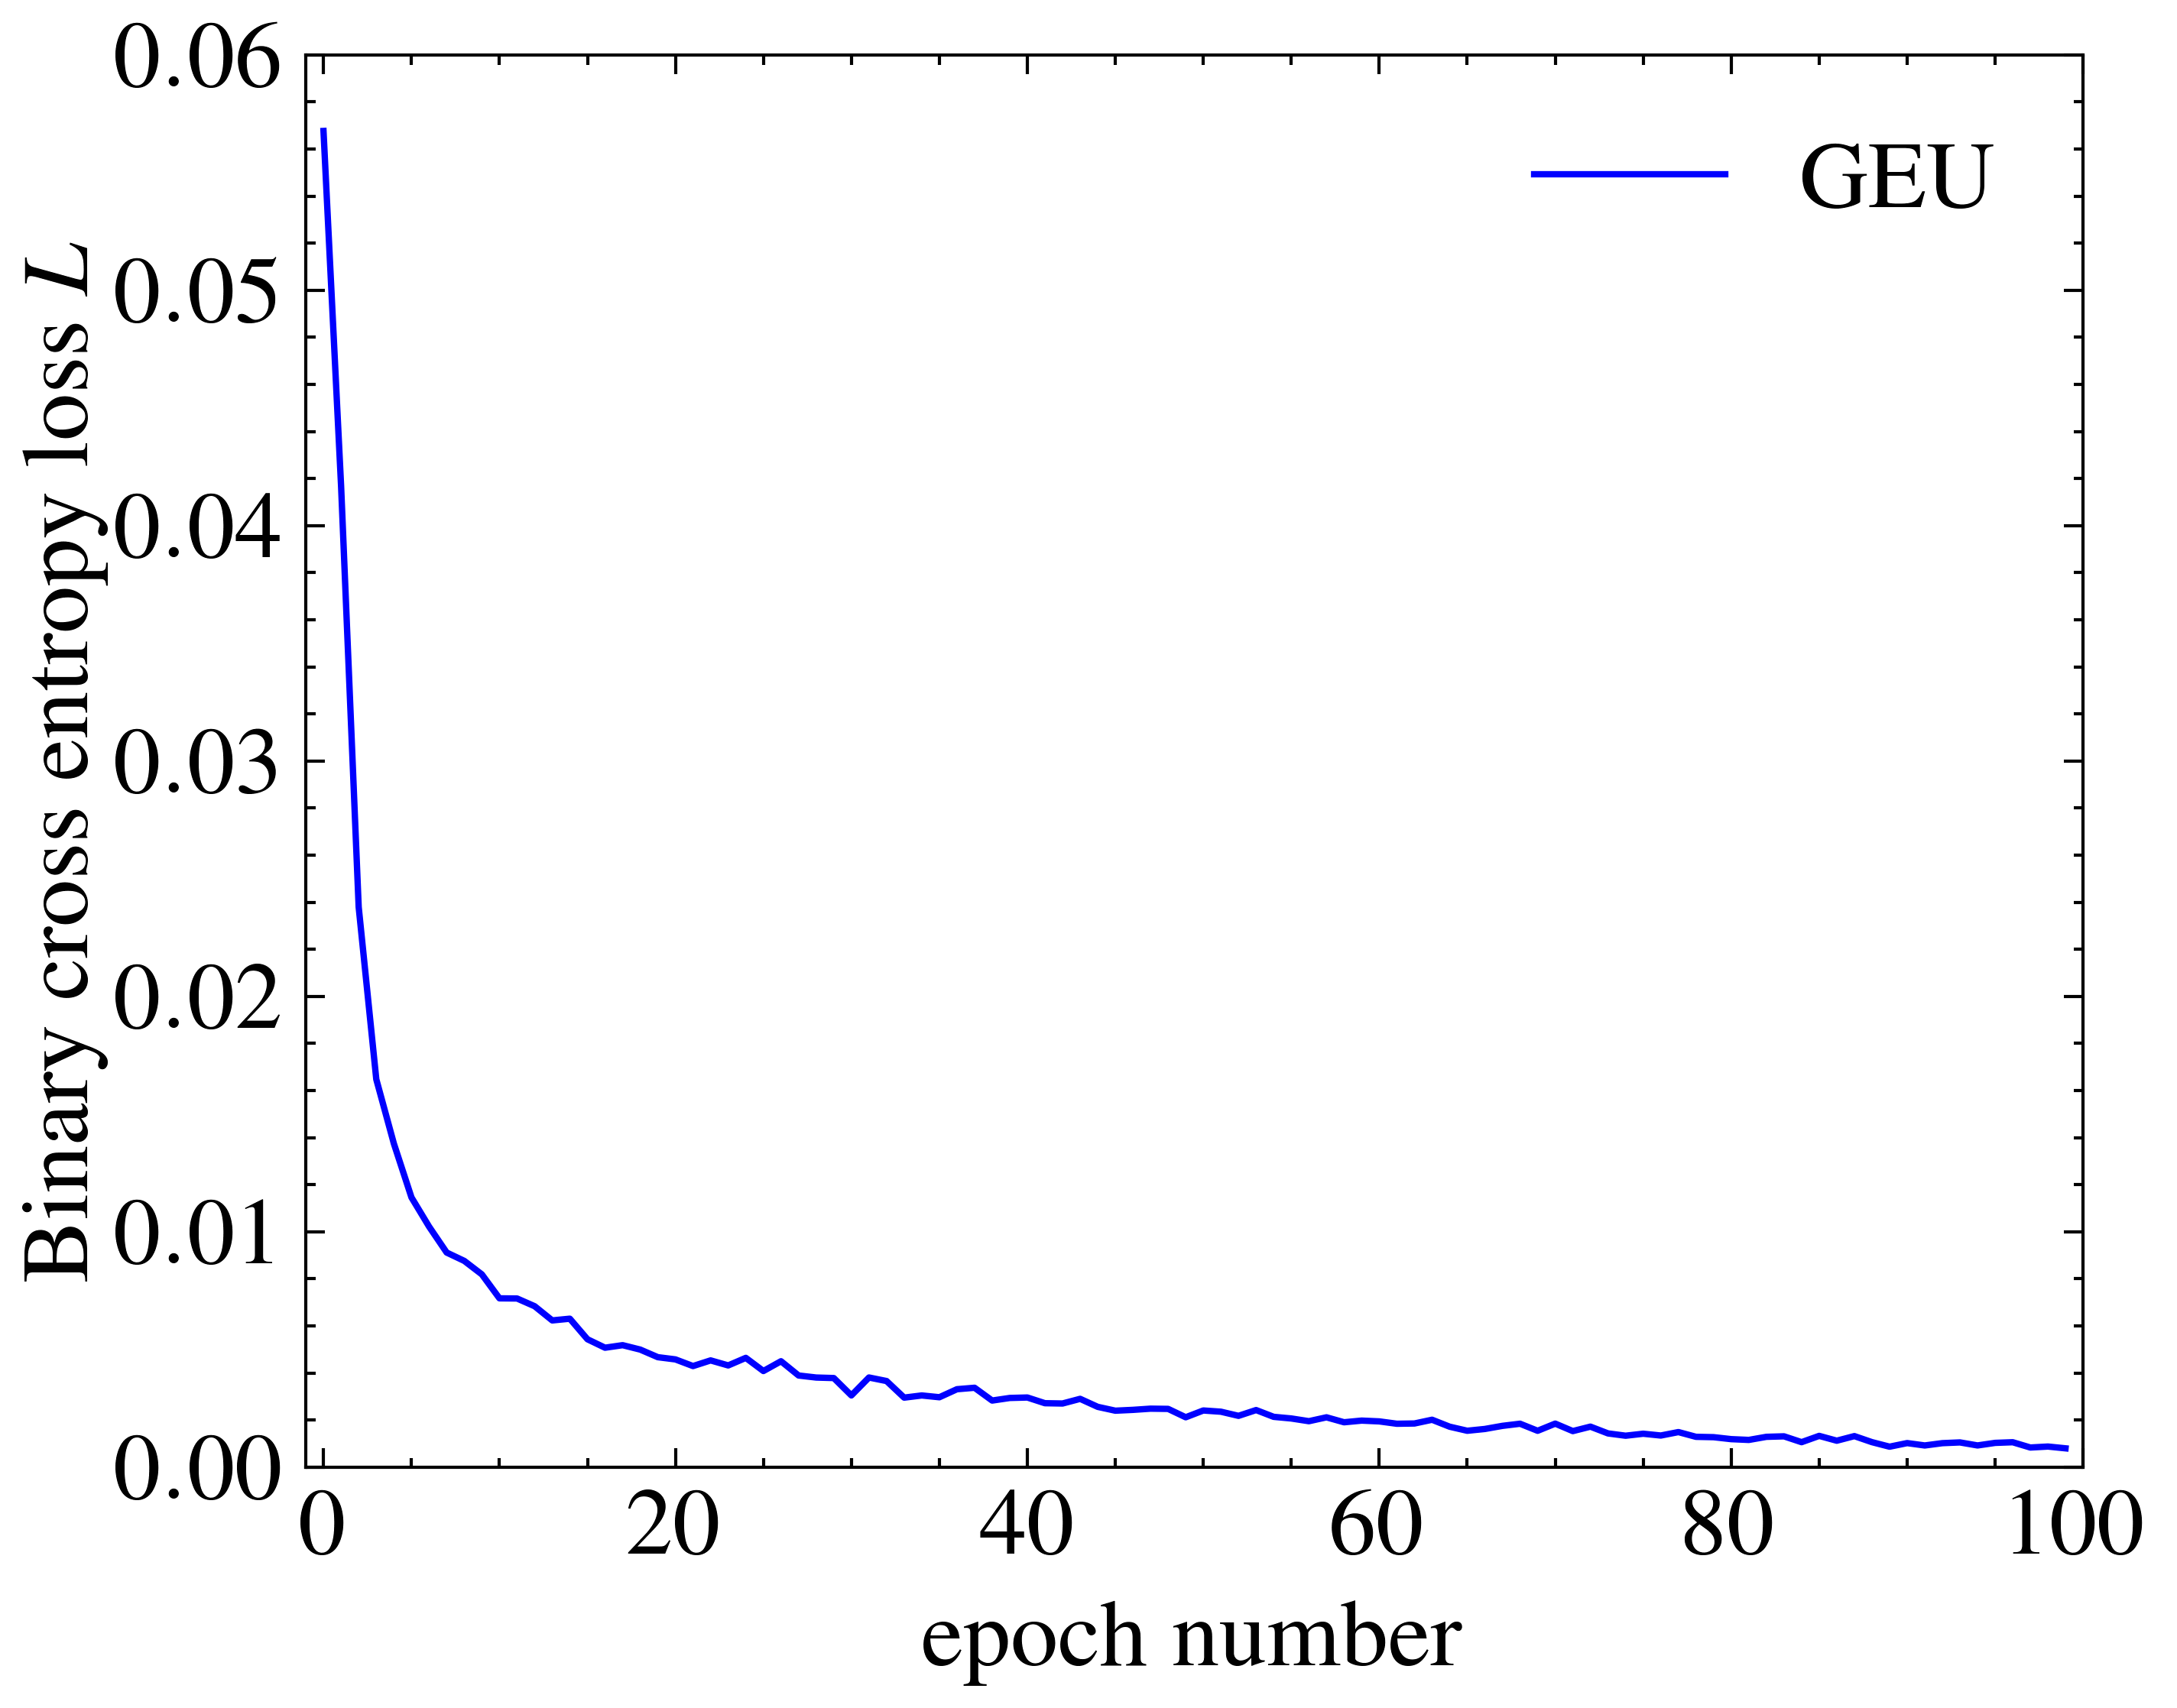

In [135]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('Binary cross entropy loss $L$', fontsize=15,labelpad = 1)
ax.set_xlim(-1, 100)
ax.set_ylim(0, 0.06)

plt.plot(np.arange(len(train_res[0])), train_res[0],'b-', lw=1,label='GEU')

ax.legend(loc='upper right', fontsize=15)

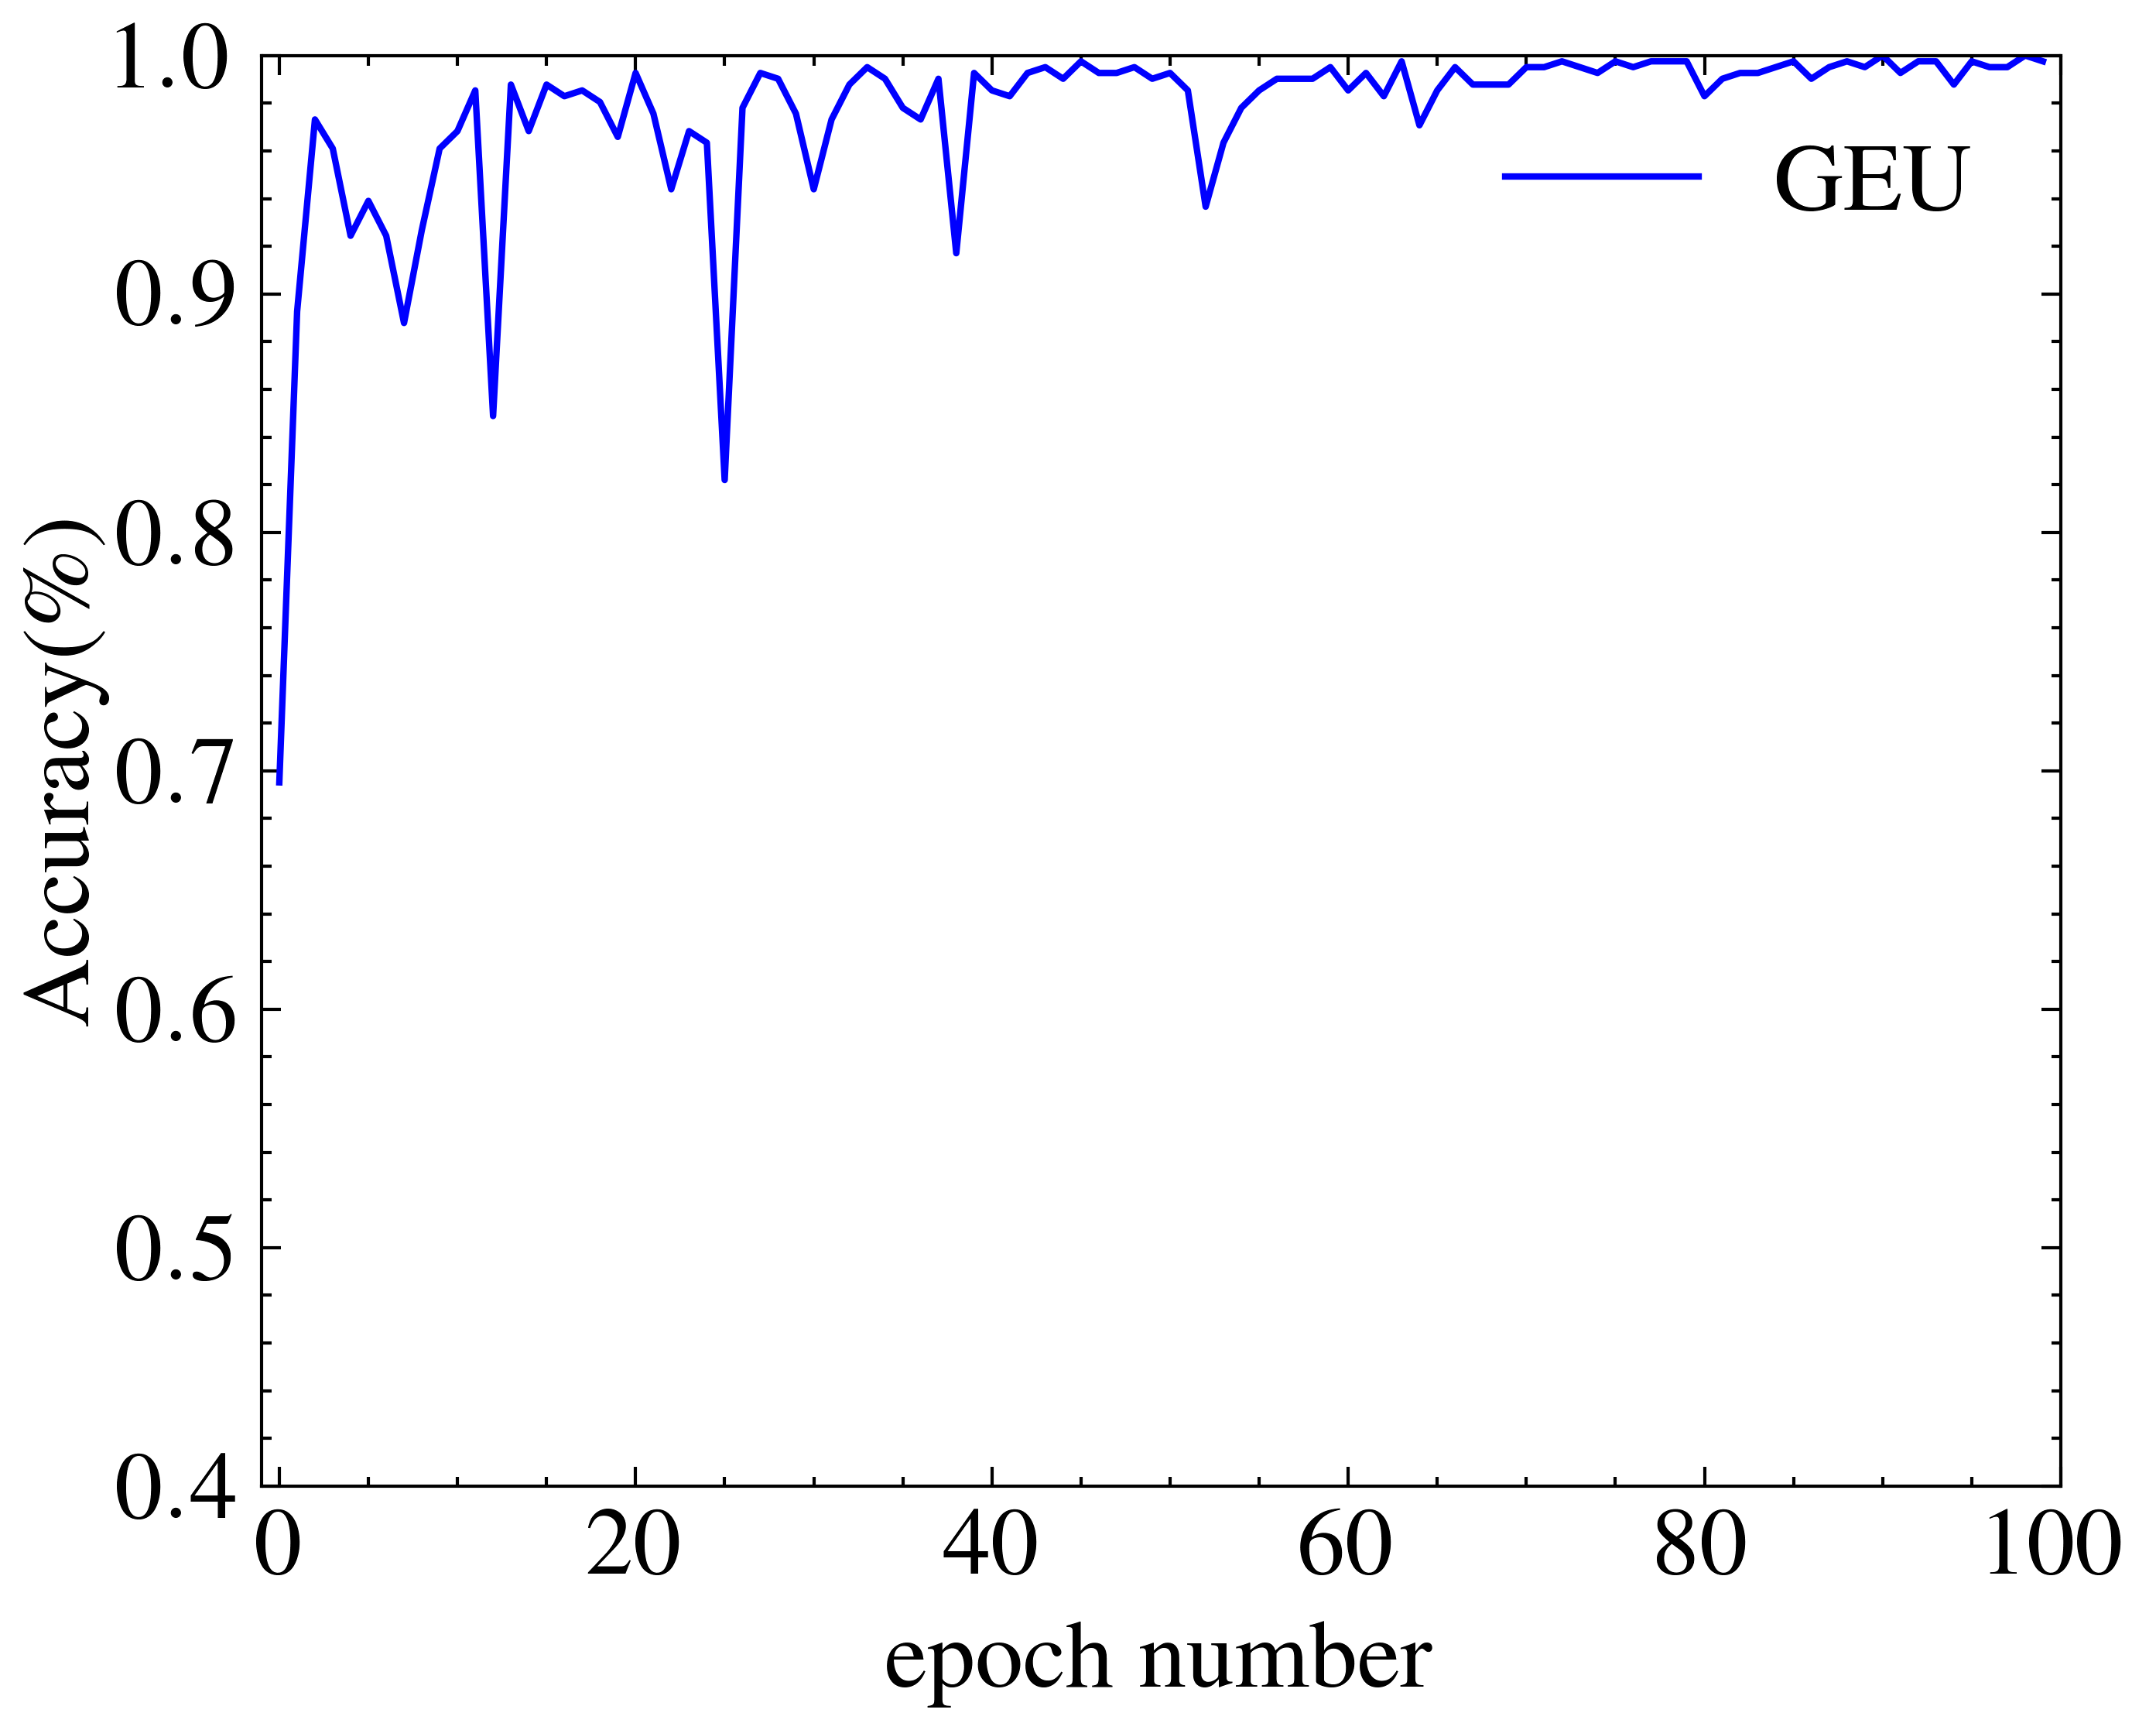

In [136]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
plt.style.use(['science','ieee'])
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel('Accuracy(\%)', fontsize=15,labelpad = 1)
ax.set_xlim(-1, 100)
ax.set_ylim(0.4, 1)

plt.plot(np.arange(len(train_res[0])), train_res[1],'b-', lw=1,label='GEU')

ax.legend(loc='upper right', fontsize=15)

In [137]:
num_of_bins = 40
every_n = 10
IXT_array, ITY_array = get_information(ws, X_train, np.concatenate([y_train, 1 - y_train], axis=1), 
                                       num_of_bins, every_n=every_n, return_matrices=True)

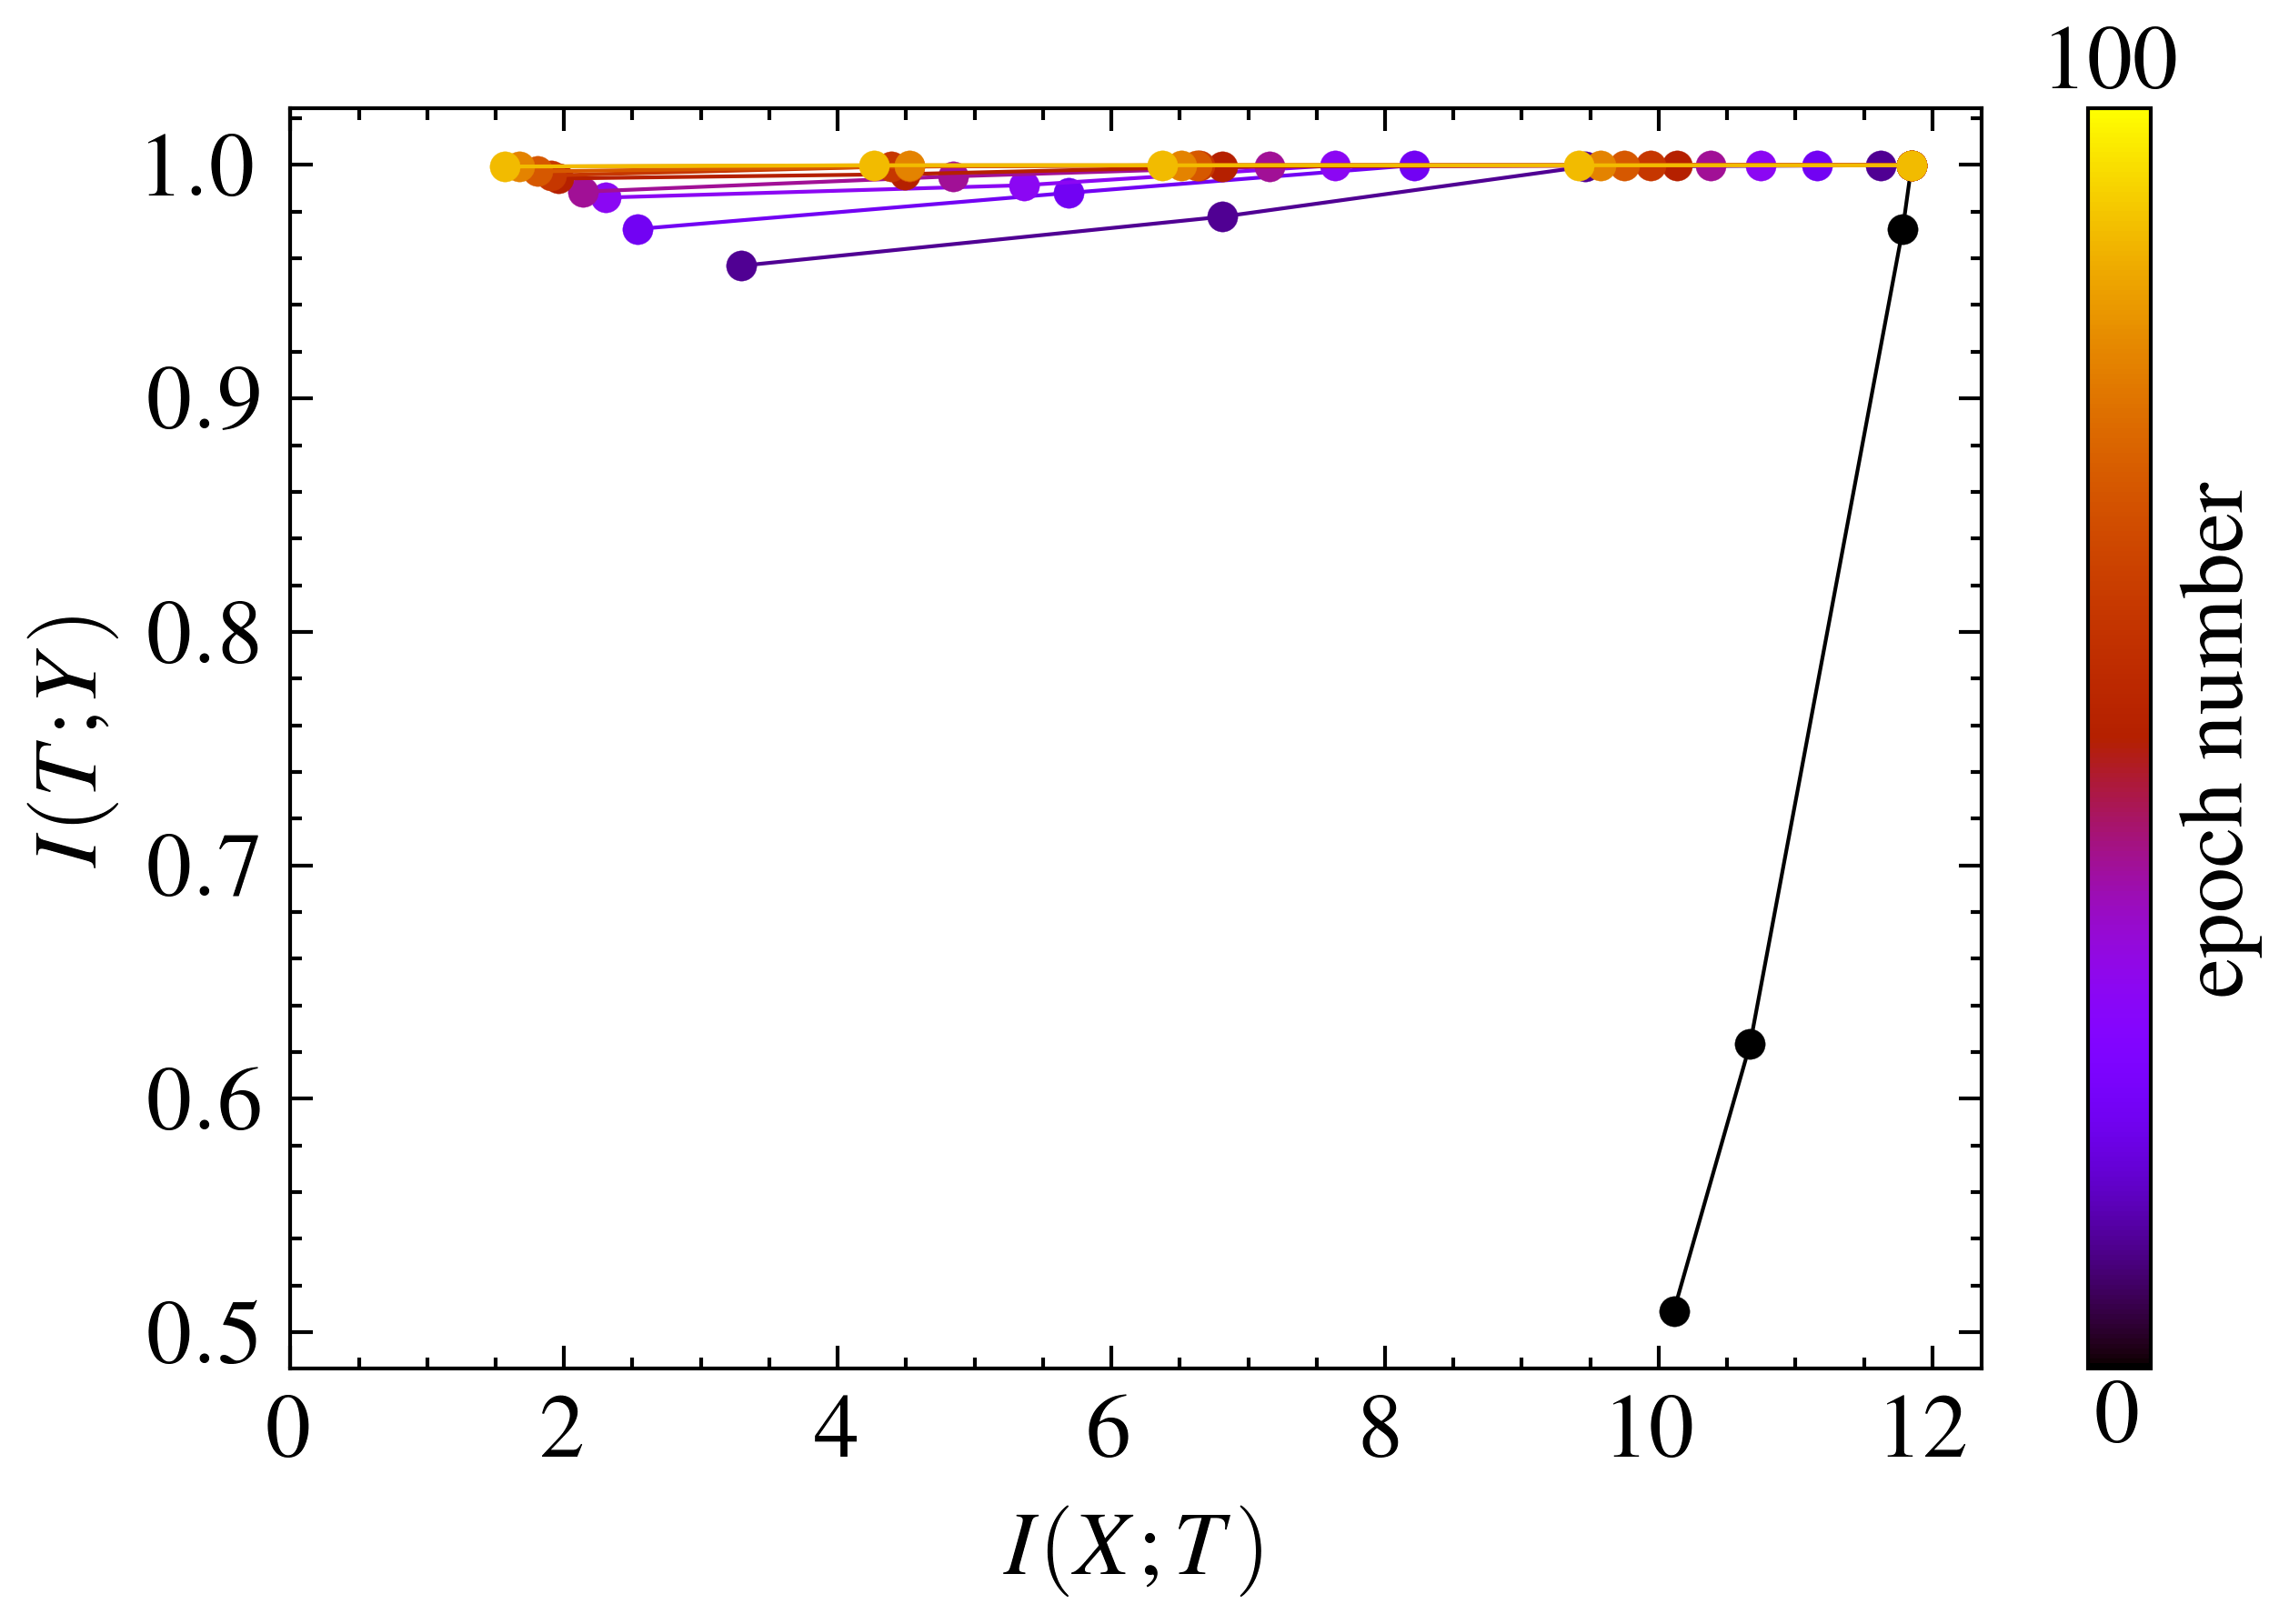

In [138]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 12})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    plt.figure(figsize=(5, 3))
    plt.xlabel('$I(X;T)$', fontsize=12)
    plt.ylabel('$I(T;Y)$', fontsize=12)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        plt.plot(IXT, ITY, marker='o', markersize=4, markeredgewidth=0.04,
                 linestyle='-', linewidth=0.5, color=colors[i * every_n], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=plt.gca(), ticks=[])
    cbar.set_label('epoch number', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([0, 2, 4, 6, 8, 10, 12])

    plt.show()

plot_information_plane(IXT_array, ITY_array, num_epochs=epochs, every_n=every_n)

In [139]:
print(IXT_array)

[[11.84784036 11.84784036 11.78299512 10.66805011 10.11001009]
 [11.84784036 11.62014402  9.46423254  6.80807272  3.29650059]
 [11.84784036 11.15815088  8.2092205   5.68972569  2.53542468]
 [11.84784036 10.74231751  7.63427514  5.36169619  2.30418549]
 [11.84784036 10.37797094  7.15725598  4.84484925  2.14044151]
 [11.84784036 10.13067164  6.80841144  4.48840813  1.96085992]
 [11.84784036  9.93762969  6.64101821  4.39285673  1.90829767]
 [11.84784036  9.74717463  6.6228072   4.5221215   1.80488353]
 [11.84784036  9.57414012  6.50772332  4.52387531  1.67355283]
 [11.84784036  9.41459825  6.3687751   4.26197142  1.56361551]]


In [140]:
print(ITY_array)

[[0.99988765 0.99988765 0.97248137 0.62348871 0.50904026]
 [0.99988765 0.99988765 0.99934506 0.97783551 0.95686313]
 [0.99988765 0.99988765 0.99988765 0.98806785 0.97257639]
 [0.99988765 0.99988765 0.99988765 0.99133915 0.98604621]
 [0.99988765 0.99988765 0.99934506 0.99513731 0.988567  ]
 [0.99988765 0.99988765 0.99934506 0.9960895  0.99421847]
 [0.99988765 0.99988765 0.99988765 0.99934506 0.9955469 ]
 [0.99988765 0.99988765 0.99988765 0.99934506 0.99728059]
 [0.99988765 0.99988765 0.99988765 0.99988765 0.99934506]
 [0.99988765 0.99988765 0.99988765 0.99988765 0.99934506]]
